In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('Case Study AF - data full.csv')
eval_data= data.copy()

In [3]:
def z_score_comp(eval_data: pd.DataFrame, metric_cols: list, z_suffix: str='_z', winsorize: bool= False, winsor_limits: tuple=(0.01, 0.99)) -> pd.DataFrame:
    eval_data = eval_data.copy()

    for col in metric_cols:
        series = eval_data[col].astype(float)

        if winsorize:
            lower, upper = series.quantile(winsor_limits)
            series = series.clip(lower=lower, upper=upper)

        mean = series.mean()
        std = series.std(ddof=0)

        if std == 0 or np.isnan(std):
            eval_data[col + z_suffix] = 0.0
        else:
            eval_data[col + z_suffix] = (series - mean) / std
    
    return eval_data

In [5]:
def archetype_score(z_eval_data: pd.DataFrame, arch_cols: list, score_name: str) -> pd.DataFrame:
    z_eval_data = z_eval_data.copy()

    z_eval_data[score_name] = z_eval_data[arch_cols].mean(axis=1, skipna=True)

    return z_eval_data

In [6]:
wr_archetypes = {'vertical_stress': ['max_speed_99', '20ydplus_route_MEAN', 'flying_20_min'], 'separation_skill': ['average_separation_99', 'separation_at_throw_VMAN', 'changedir_route_MEAN'], 
                 'YAC_creator': ['expected_yac_at_catch_MEAN', 'YACOE_MEAN'], 'reliable_target': ['targeted_tightwindow_catch_SUM', 'CPOE_MEAN', 'targeted_catch_SUM']}

all_metrics = sorted({m for mets in wr_archetypes.values() for m in mets})

eval_data = z_score_comp(eval_data=eval_data, metric_cols=all_metrics, winsorize=True)

for arch_name, raw_cols in wr_archetypes.items():
    z_cols = [c + '_z' for c in raw_cols]
    eval_data = archetype_score(z_eval_data=eval_data, arch_cols=z_cols, score_name=f'{arch_name}_score')


In [7]:
score_cols = [f'{k}_score' for k in wr_archetypes.keys()]

eval_data[['player_name', *score_cols ]].head()

,player_name,vertical_stress_score,separation_skill_score,YAC_creator_score,reliable_target_score
0,Ronnel Johnson,-1.065082,0.626643,0.561221,0.087974
1,Tailique Williams,-0.581331,1.563009,0.077752,-0.297144
2,Joaquin Davis,0.123941,0.401991,-0.427542,0.898127
3,Jaden Barnes,-0.036742,-0.034177,0.659359,1.575882
4,Sean Brown,-0.230456,-0.016858,-0.720762,0.514686


In [8]:
export_cols = ['player_name', 'total_plays', 'season', 'offense_team','vertical_stress_score', 'separation_skill_score', 'YAC_creator_score', 'reliable_target_score']

 # eval_data[export_cols].to_csv('wr_arch_scores.csv', index=False)

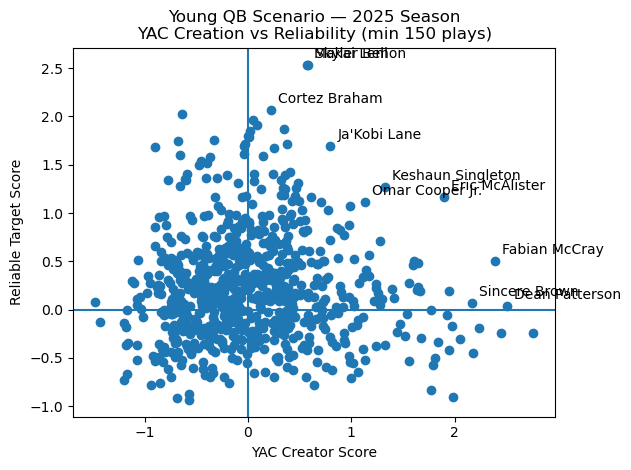

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

min_plays = 150
annotate_n = 10

young_qb = eval_data[
    (eval_data["season"] == 2025) &
    (eval_data["total_plays"] >= min_plays) &
    (eval_data["YAC_creator_score"].notna()) &
    (eval_data["reliable_target_score"].notna())
].copy()

plt.figure()
plt.scatter(
    young_qb["YAC_creator_score"],
    young_qb["reliable_target_score"]
)

# quadrant lines (z-score mean)
plt.axhline(0)
plt.axvline(0)

plt.xlabel("YAC Creator Score")
plt.ylabel("Reliable Target Score")
plt.title(
    f"Young QB Scenario — 2025 Season\n"
    f"YAC Creation vs Reliability (min {min_plays} plays)"
)


# identify and annotate
annotated_young_qb = (young_qb[(young_qb["YAC_creator_score"] > 0) & (young_qb["reliable_target_score"] > 0)].assign(signal=lambda df: (df["YAC_creator_score"] + df["reliable_target_score"]))
                      .sort_values("signal", ascending=False).head(annotate_n))

for _, r in annotated_young_qb.iterrows(): plt.annotate( r["player_name"], (r["YAC_creator_score"], r["reliable_target_score"]), textcoords="offset points", xytext=(5, 5))

plt.tight_layout()
plt.show()

#output_table
annotated_young_qb_table = annotated_young_qb[
    [
        "player_name",
        'offense_team',
        "total_plays",
        "YAC_creator_score",
        "reliable_target_score",
        "signal"
    ]
].reset_index(drop=True)

annotated_young_qb_table.to_csv('annotated_qb_table_2025.csv', index=False)



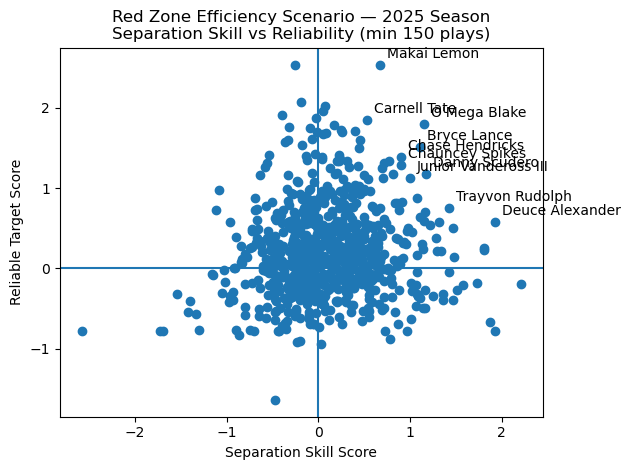

,player_name,total_plays,separation_skill_score,reliable_target_score,signal
0,Makai Lemon,501,0.670856,2.536913,3.207769
1,O'Mega Blake,531,1.155931,1.795331,2.951262
2,Bryce Lance,285,1.106524,1.512421,2.618945
3,Deuce Alexander,381,1.933202,0.576687,2.509889
4,Carnell Tate,226,0.533589,1.846364,2.379953
5,Danny Scudero,328,1.170850,1.178519,2.349369
6,Chase Hendricks,477,0.900115,1.390294,2.290409
7,Chauncey Spikes,286,0.905527,1.282557,2.188083
8,Trayvon Rudolph,344,1.426362,0.750286,2.176648
9,Junior Vandeross III,427,0.997429,1.124082,2.121511


In [21]:
import matplotlib.pyplot as plt

# parameters
min_plays = 150
annotate_n = 10

red_zone = eval_data[
    (eval_data["season"] == 2025) &
    (eval_data["total_plays"] >= min_plays) &
    (eval_data["separation_skill_score"].notna()) &
    (eval_data["reliable_target_score"].notna())
].copy()

plt.figure()
plt.scatter(
    red_zone["separation_skill_score"],
    red_zone["reliable_target_score"]
)

plt.axhline(0)
plt.axvline(0)

plt.xlabel("Separation Skill Score")
plt.ylabel("Reliable Target Score")
plt.title(
    f"Red Zone Efficiency Scenario — 2025 Season\n"
    f"Separation Skill vs Reliability (min {min_plays} plays)"
)

# identify and annotate
annotated_red_zone = (
    red_zone[
        (red_zone["separation_skill_score"] > 0) &
        (red_zone["reliable_target_score"] > 0)
    ]
    .assign(signal=lambda df: df["separation_skill_score"] + df["reliable_target_score"])
    .sort_values("signal", ascending=False)
    .head(annotate_n)
)

for _, r in annotated_red_zone.iterrows():
    plt.annotate(
        r["player_name"],
        (r["separation_skill_score"], r["reliable_target_score"]),
        textcoords="offset points",
        xytext=(5, 5)
    )

plt.tight_layout()
plt.show()

# output table of annotated players (the same ones you labeled)
annotated_red_zone_table = annotated_red_zone[
    [
        "player_name",
        "total_plays",
        "separation_skill_score",
        "reliable_target_score",
        "signal"
    ]
].reset_index(drop=True)

annotated_red_zone_table
